In [1]:
# import data
import pandas as pd
from os import path
indir = '/cellar/users/hsher/course_project_2020/data'
rna = pd.read_csv(path.join(indir, 'tpm_96_nodup.tsv'), sep = '\t', index_col = 0) 
rna = rna.loc[rna.sum(axis = 1)!=0] # remove RNA expression = 0 for all patients
pt = pd.read_csv(path.join(indir, 'patient_info.csv'), index_col = 0)

In [2]:
rna.shape

(56472, 96)

# Statistical test for first round of feature selection
else ~60000 genes is too much

In [3]:
recur_rna = rna[pt.loc[pt['recurStatus'] == 'R'].index]
norecur_rna = rna[pt.loc[pt['recurStatus'] == 'N'].index]
from scipy.stats import mannwhitneyu

stat = pd.DataFrame(index = rna.index, columns = ['stat', 'p'])

for gene in rna.index:
    s, p = mannwhitneyu(recur_rna.loc[gene], norecur_rna.loc[gene])
    stat.loc[gene] = [s,p]

In [4]:
stat.loc[stat['p']<0.05].sort_values(by = 'p')

,stat,p
gene_id,,
ENSG00000212694,474.5,1.38014e-05
ENSG00000172201,440,1.6768e-05
ENSG00000279198,462,2.80918e-05
ENSG00000259657,632.5,3.72484e-05
ENSG00000243260,579.5,4.01381e-05
...,...,...
ENSG00000218049,782,0.0499595
ENSG00000264242,782,0.0499595
ENSG00000260352,782,0.0499595


In [5]:
selected_feature = stat.loc[stat['p']<0.05].sort_values(by = 'p').index[:3000]

# Tune neural network hidden layer size

In [6]:
#selected_feature = rna.loc[rna.std(axis = 1)>100].index

In [7]:
X = rna.loc[selected_feature].values
#X = rna.values
y = pt.loc[rna.columns, 'recurStatus'].map({'N': 0, 'R': 1}).values

In [8]:
X.shape

(3000, 96)

In [9]:
y.shape

(96,)

In [10]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.2, random_state=None)

In [11]:
X_train.shape

(76, 3000)

In [12]:
X_test.shape

(20, 3000)

In [13]:
y_test.sum()

6

# select number of layers
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
def model_evaluation(layer = (5, 9,8,4), n_iter = 50):
    accuracy = []
    cvs = []
    for i in range(n_iter):
        X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.2, random_state=None)

        clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=layer, random_state=None, early_stopping = True, max_iter = 300)


        clf.fit(X_train, y_train)
        cv = cross_val_score(clf, X_train, y_train, cv=10, scoring='recall_macro')
        y_test_hat = clf.predict(X_test)
        acc = accuracy_score(y_test, y_test_hat)
        
        accuracy.append(acc)
        cvs.append([cv.mean(), cv.std()])
    return accuracy, cvs

layer  = [(10,10,10,10,10,10,10,10), (10,10,10,10,10,10,10,10,10),(10,10,10,10,10,10,10,10,10,10),(10,10,10,10,10,10,10,10,10,10,10), (10,10,10,10,10,10,10,10,10,10,10,10)]
df = pd.DataFrame(index = [str(l) for l in layer], columns = ['acc_mean', 'acc_std', 'cv_mean', 'cv_std'])
for l in layer:
    acc, cvs = model_evaluation(layer = l)
    acc_mean = np.mean(acc)
    acc_std = np.std(acc)
    cv_mean = np.mean([c[0] for c in cvs])
    cv_std = np.std([c[0] for c in cvs])
    df.loc[str(l)] = [acc_mean, acc_std, cv_mean, cv_std]

df

# Migrate to keras and do explainable deep learning
https://www.machinecurve.com/index.php/2019/11/25/visualizing-keras-cnn-attention-saliency-maps/

In [14]:
from math import ceil
# build keras model: 
no_classes = 2
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import keras
from keras.callbacks import EarlyStopping
from keras.regularizers import l1

y_train_class = keras.utils.to_categorical(y_train, no_classes)
y_test_class = keras.utils.to_categorical(y_test, no_classes)


model = Sequential()
model.add(Dense(10, input_dim=X.shape[0], activation='relu',kernel_regularizer=l1(0.005)))
model.add(Dense(10, activation='relu',kernel_regularizer=l1(0.005)))
#model.add(Dense(10, activation='relu',kernel_regularizer=l1(0.001)))
# add saliency map layer
model.add(Dense(no_classes, activation='softmax', name='saliency_map'))


batch_size = X_train.shape[1]
no_epochs = 10000
validation_split = 0.2
verbosity = 1

# use early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500)



model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(X_train, y_train_class,
          batch_size=ceil(batch_size/3),
          epochs=no_epochs,
          verbose=0,
          validation_split=validation_split,
            callbacks=[es])
score = model.evaluate(X_test, y_test_class, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Using TensorFlow backend.


Epoch 01155: early stopping
Test loss: 1.267240285873413 / Test accuracy: 0.800000011920929


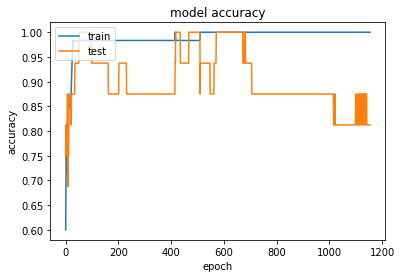

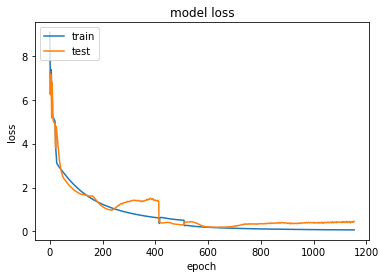

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# find layer
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

import numpy as np

# Find the index of the to be visualized layer above
layer_index = utils.find_layer_idx(model, 'saliency_map')

# Swap softmax with linear: compute how the output changes with respect to a change in input. 
model.layers[layer_index].activation = activations.linear
model = utils.apply_modifications(model)  

indices_to_visualize = np.where(y_test == 1)[0]
indices_to_visualize.tolist()

# Visualize
all_vis = []
for index_to_visualize in indices_to_visualize:
    # Get input
    input_image = X_test[index_to_visualize]
    input_class = np.argmax(y_test_class[index_to_visualize])
    
    visualization = visualize_saliency(model, layer_index, filter_indices=input_class, seed_input=input_image,grad_modifier='relu',keepdims=True)
    
    all_vis.append(visualization)

/cellar/users/hsher/miniconda3/envs/exrna/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


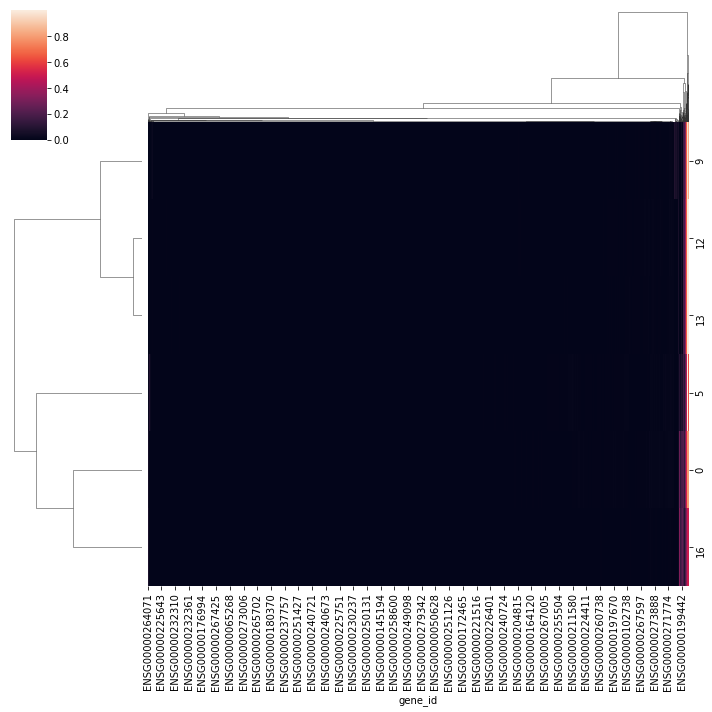

In [17]:
import seaborn as sns
indv_saliency = pd.DataFrame(np.stack(all_vis), columns = selected_feature, index = indices_to_visualize)
sns.clustermap(indv_saliency)

# What is the neural network looking at

- which gene-->
- expression
- logscale color

In [40]:
# id converter
import mygene
mg = mygene.MyGeneInfo()
id_converter = mg.querymany(selected_feature, scopes='ensemblgene', fields = ['symbol','ensembl.transcript'], as_dataframe =True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
Finished.


/cellar/users/hsher/miniconda3/envs/exrna/lib/python3.7/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


136 input query terms found no hit:
	['ENSG00000266825', 'ENSG00000281239', 'ENSG00000273009', 'ENSG00000254667', 'ENSG00000266259', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


False

In [19]:
import gseapy as gp
def gsea_on_vis(vis, id_converter = id_converter, gene_sets=['KEGG_2016','KEGG_2013']):
    gene_rank = vis.rank(ascending = False).sort_values(ascending = True)
    gene_list = id_converter.loc[gene_rank.index, 'symbol'].dropna().tolist()
    #print(gene_list)
    enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
    return enr

In [20]:
e = gsea_on_vis(indv_saliency.loc[16])

2020-05-27 13:56:05,465 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.5
2020-05-27 13:56:10,962 Warning: No enrich terms using library KEGG_2013 when cutoff = 0.5


In [25]:
e.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,N-Glycan biosynthesis Homo sapiens hsa00510,9/49,0.262328,1.0,0,0,1.282636,1.716372,ALG8;GANAB;B4GALT1;MAN1A2;MGAT5B;ALG2;ALG3;DOL...
1,KEGG_2016,Type I diabetes mellitus Homo sapiens hsa04940,8/43,0.267992,1.0,0,0,1.299207,1.710792,ICA1;GAD2;FASLG;HLA-F;HLA-G;HLA-DQA1;HSPD1;HLA...
2,KEGG_2016,Cell cycle Homo sapiens hsa04110,20/124,0.318387,1.0,0,0,1.126329,1.289069,RB1;GSK3B;CDKN1B;PCNA;GADD45B;MCM7;PRKDC;GADD4...
3,KEGG_2016,Homologous recombination Homo sapiens hsa03440,5/29,0.403004,1.0,0,0,1.204007,1.094211,MUS81;RAD51B;POLD1;TOP3A;RAD54L
4,KEGG_2016,Fructose and mannose metabolism Homo sapiens h...,5/32,0.491962,1.0,0,0,1.091131,0.773997,PFKFB3;PMM2;ALDOC;ALDOB;HK1
...,...,...,...,...,...,...,...,...,...,...
428,KEGG_2013,HSA04010 MAPK SIGNALING PATHWAY,16/257,0.999983,1.0,0,0,0.434754,0.000008,MAP3K2;MAP2K3;ATF2;GADD45B;GADD45A;FASLG;DUSP8...
429,KEGG_2013,HSA04630 JAK STAT SIGNALING PATHWAY,6/153,0.999990,1.0,0,0,0.273853,0.000003,IFNAR2;IFNGR1;SPRY3;EP300;PIK3CB;TYK2
430,KEGG_2013,HSA04530 TIGHT JUNCTION,4/136,0.999994,1.0,0,0,0.205389,0.000001,CSNK2A1;CTNNA1;F11R;JAM3
431,KEGG_2013,HSA04060 CYTOKINE CYTOKINE RECEPTOR INTERACTION,13/257,0.999995,1.0,0,0,0.353238,0.000002,IFNAR2;IFNGR1;HGF;TNFRSF9;TNFRSF10A;FASLG;CX3C...


In [23]:
indv_saliency.sum(axis = 0).sort_values(ascending = False)

gene_id
ENSG00000201016    5.239075
ENSG00000207176    4.773088
ENSG00000206980    4.560893
ENSG00000201555    4.121855
ENSG00000207164    3.988770
                     ...   
ENSG00000280114    0.000000
ENSG00000264024    0.000000
ENSG00000130413    0.000000
ENSG00000264623    0.000000
ENSG00000212694    0.000000
Length: 3000, dtype: float32

In [27]:
# simple plotting function
from gseapy.plot import barplot, dotplot
%matplotlib inline
# to save your figure, make sure that ``ofname`` is not None
barplot(e.res2d,title='KEGG',)

'Warning: No enrich terms using library KEGG when cutoff = 0.05'

In [33]:
rnk = indv_saliency.sum(axis = 0).sort_values(ascending = False).to_frame()
rnk.index = id_converter.loc[rnk.index, 'symbol']

In [35]:
pre_res = gp.prerank(rnk=rnk, gene_sets='KEGG_2016',
                     processes=4,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='test/prerank_report_kegg', format='png', seed=6)

2020-05-27 14:05:58,104 Input gene rankings contains NA values(gene name and ranking value), drop them all!


In [38]:
pre_res.res2d.sort_values(by = 'pval').head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Regulation of actin cytoskeleton Homo sapiens hsa04810,0.892023,1.346293,0.120000,1.0,214,16,ITGB2;WASL;IQGAP1;BAIAP2;PIP4K2B;VCL;LIMK2;ITG...,ITGB2;WASL
Cell adhesion molecules (CAMs) Homo sapiens hsa04514,0.748335,1.123968,0.242424,1.0,142,17,ITGB2;PVR;F11R;HLA-G;PTPRC;CD2;ICOSLG;CDH1;HLA...,ITGB2;PVR;F11R
Focal adhesion Homo sapiens hsa04510,0.857822,1.214975,0.260000,1.0,202,16,BAD;LAMC2;VEGFA;PARVB;PDPK1;GSK3B;VCL;ITGB8;HG...,BAD;LAMC2;VEGFA;PARVB
cAMP signaling pathway Homo sapiens hsa04024,0.780270,1.129838,0.270000,1.0,199,15,BAD;HTR1D;GLI1;GABBR2;AMH;ADORA1;EP300;CALM2;P...,BAD;HTR1D;GLI1;GABBR2;AMH;ADORA1;EP300
Ras signaling pathway Homo sapiens hsa04014,0.716020,1.076016,0.280000,1.0,227,17,SYNGAP1;BAD;VEGFA;PLA1A;GNG5;KITLG;TBK1;FASLG;...,SYNGAP1;BAD;VEGFA
